In [18]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
import pandas as pd
import re
from textblob import TextBlob
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np

In [19]:
class StockSentimentAnalysis:
    def __init__(self, data):
        self.data = data
        self.vectorizer = TfidfVectorizer(max_features=5000)  # Initialize the vectorizer

    def preprocess_data(self):
        # Combine all headlines for each date into a single text field
        self.data['Combined_News'] = self.data.iloc[:, 2:].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

        # Clean the text data
        self.data['Combined_News'] = self.data['Combined_News'].apply(self.clean_text)

    @staticmethod
    def clean_text(text):
        # Remove non-alphabetic characters and convert to lowercase
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        text = text.lower()
        return text

    def perform_eda(self):
        # Check for missing values
        missing_values = self.data.isnull().sum()

        # Summary statistics for numerical columns
        summary_stats = self.data.describe()

        # Distribution of labels
        label_distribution = self.data['Label'].value_counts()

        # Word cloud for positive and negative labels
        positive_text = ' '.join(self.data[self.data['Label'] == 1]['Combined_News'])
        negative_text = ' '.join(self.data[self.data['Label'] == 0]['Combined_News'])

        wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
        wordcloud_negative = WordCloud(width=800, height=400, background_color='black').generate(negative_text)

        # Plot the word clouds
        plt.figure(figsize=(14, 7))
        plt.subplot(1, 2, 1)
        plt.imshow(wordcloud_positive, interpolation='bilinear')
        plt.axis('off')
        plt.title('Word Cloud - Positive Sentiment')

        plt.subplot(1, 2, 2)
        plt.imshow(wordcloud_negative, interpolation='bilinear')
        plt.axis('off')
        plt.title('Word Cloud - Negative Sentiment')

        plt.show()

        # Plot label distribution
        plt.figure(figsize=(8, 5))
        sns.countplot(x='Label', data=self.data)
        plt.title('Label Distribution')
        plt.show()

        return missing_values, summary_stats, label_distribution

    def build_models(self):
        # Preprocess data
        self.preprocess_data()

        # Split the data into train and test based on the date
        train = self.data[self.data['Date'] < '20150101']
        test = self.data[self.data['Date'] > '20141231']

        # Perform feature engineering on training data and fit vectorizer
        X_train, y_train = self.feature_engineering_data(train, fit_vectorizer=True)

        # Perform feature engineering on test data using the fitted vectorizer
        X_test, y_test = self.feature_engineering_data(test, fit_vectorizer=False)

        # Random Forest Model
        rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
        rf_model.fit(X_train, y_train)

        # Simplified XGBoost Model
        xgb_model = XGBClassifier(n_estimators=50, max_depth=3, use_label_encoder=False, eval_metric='logloss', random_state=42)
        xgb_model.fit(X_train, y_train)

        # Evaluate models
        rf_pred_prob = rf_model.predict_proba(X_test)[:, 1]
        xgb_pred_prob = xgb_model.predict_proba(X_test)[:, 1]

        rf_pred = rf_model.predict(X_test)
        xgb_pred = xgb_model.predict(X_test)

        rf_accuracy = accuracy_score(y_test, rf_pred)
        xgb_accuracy = accuracy_score(y_test, xgb_pred)

        rf_report = classification_report(y_test, rf_pred)
        xgb_report = classification_report(y_test, xgb_pred)

        # ROC and AUC
        rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_pred_prob)
        xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_pred_prob)

        rf_auc = roc_auc_score(y_test, rf_pred_prob)
        xgb_auc = roc_auc_score(y_test, xgb_pred_prob)

        # Plot ROC curves
        plt.figure(figsize=(10, 6))
        plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.2f})')
        plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost (AUC = {xgb_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--', label='Random')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        plt.show()

        return {
            "RandomForest": {"accuracy": rf_accuracy, "report": rf_report, "auc": rf_auc},
            "XGBoost": {"accuracy": xgb_accuracy, "report": xgb_report, "auc": xgb_auc}
        }

    def feature_engineering_data(self, data, fit_vectorizer=False):
        if fit_vectorizer:
            X = self.vectorizer.fit_transform(data['Combined_News'])
        else:
            X = self.vectorizer.transform(data['Combined_News'])
        y = data['Label']
        return X, y


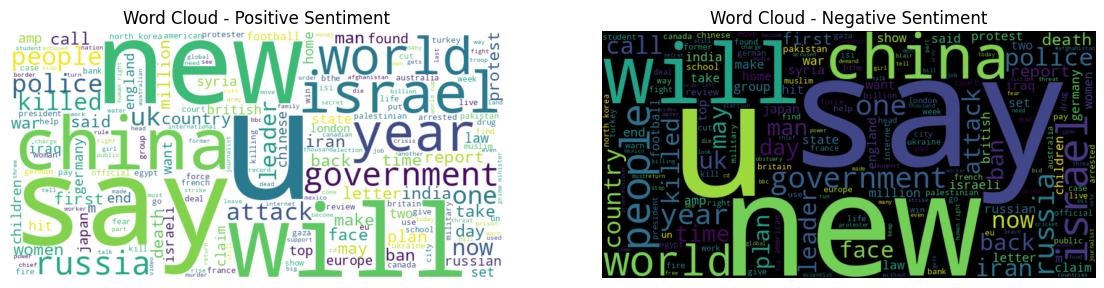

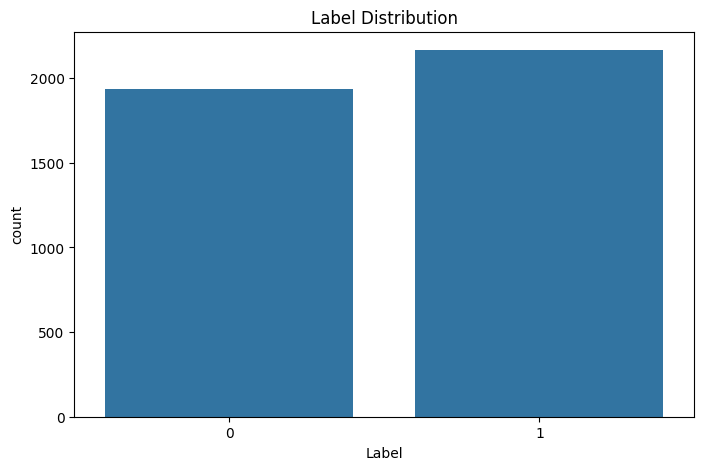

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:35:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


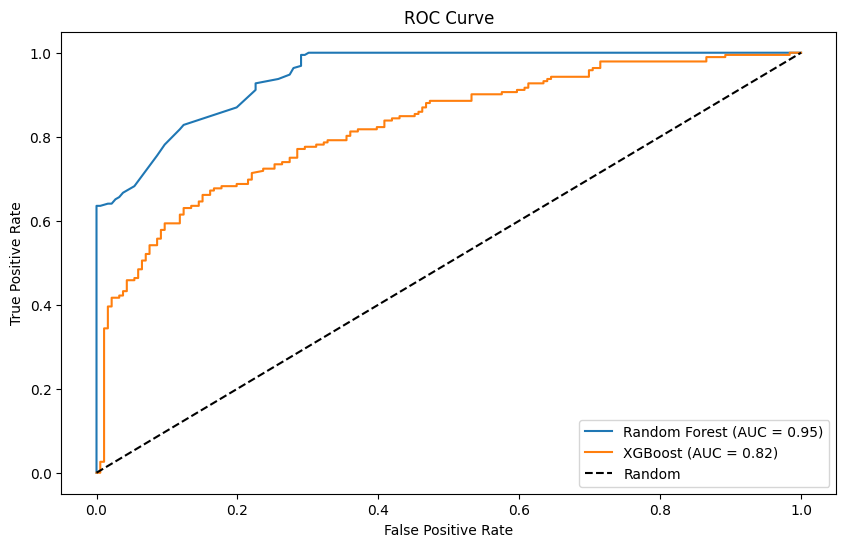

{'RandomForest': {'accuracy': 0.843915343915344,
  'report': '              precision    recall  f1-score   support\n\n           0       0.89      0.77      0.83       186\n           1       0.81      0.91      0.86       192\n\n    accuracy                           0.84       378\n   macro avg       0.85      0.84      0.84       378\nweighted avg       0.85      0.84      0.84       378\n',
  'auc': 0.9464885752688172},
 'XGBoost': {'accuracy': 0.7248677248677249,
  'report': '              precision    recall  f1-score   support\n\n           0       0.75      0.66      0.70       186\n           1       0.70      0.79      0.75       192\n\n    accuracy                           0.72       378\n   macro avg       0.73      0.72      0.72       378\nweighted avg       0.73      0.72      0.72       378\n',
  'auc': 0.8246107750896058}}

In [21]:
data=pd.read_csv('Data.csv', encoding = "ISO-8859-1")
analysis = StockSentimentAnalysis(data)
analysis.preprocess_data()
missing_values, summary_stats, label_distribution = analysis.perform_eda()
model_performance = analysis.build_models()

model_performance
